In [1]:
import datamol as dm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tdc.single_pred import ADME

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from mood.transformer import ModelSpaceTransformer
from mood.preprocessing import standardize_smiles
from mood.distance import compute_knn_distance
from mood.visualize import plot_distance_distributions

In [2]:
lipophilicity = ADME(name = 'Lipophilicity_AstraZeneca')
data = lipophilicity.get_data()

smiles = data[lipophilicity.entity1_name].to_numpy()
smiles = dm.utils.parallelized(lambda smi: dm.to_smiles(dm.to_mol(smi)), smiles)
smiles = dm.utils.parallelized(standardize_smiles, smiles)

X = np.array(dm.utils.parallelized(dm.to_fp, smiles))
y = data["Y"].to_numpy()

Found local copy...
Loading...
Done!


In [3]:
virtual_screening = pd.read_parquet("gs://experiments-output/mood-v2/downstream_applications/representations/virtual_screening/ECFP.parquet")
virtual_screening_fps = np.stack(virtual_screening["representation"].to_numpy(), axis=0)

optimization = pd.read_parquet("gs://experiments-output/mood-v2/downstream_applications/representations/optimization/ECFP.parquet")
optimization_fps = np.stack(optimization["representation"].to_numpy(), axis=0)

In [4]:
mlp_model = MLPRegressor()
mlp_model.fit(X, y)

rf_model = RandomForestRegressor()
rf_model.fit(X, y)

RandomForestRegressor()

In [5]:
input_distances = compute_knn_distance(X, [X, optimization_fps, virtual_screening_fps], n_jobs=-1)

In [6]:
trans = ModelSpaceTransformer(mlp_model)

mlp_space_train = trans(X)
mlp_space_virtual_screening = trans(virtual_screening_fps)
mlp_space_optimization = trans(optimization_fps)

mlp_distances = compute_knn_distance(
    mlp_space_train, 
    [mlp_space_train, mlp_space_optimization, mlp_space_virtual_screening], 
    n_jobs=-1
)

In [7]:
trans = ModelSpaceTransformer(rf_model)

rf_space_train = trans(X)
rf_space_virtual_screening = trans(virtual_screening_fps)
rf_space_optimization = trans(optimization_fps)

rf_distances = compute_knn_distance(
    rf_space_train, 
    [rf_space_train, rf_space_optimization, rf_space_virtual_screening], 
    n_jobs=-1
)

In [8]:
def plot_distance_distributions_2(distances, labels, colors, styles):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])
        
    # Visualize all splitting methods
    for idx, dist in enumerate(distances): 
        sns.kdeplot(dist, color=colors[idx], linestyle=styles[idx], ax=ax, label=labels[idx], alpha=0.7)
    
    ax.set_xlabel(f"Distance")
    ax.legend()
        
    return ax

In [9]:
np.array_equal(input_distances[1], input_distances[2])

False

In [14]:
cmap = sns.color_palette("rocket", 3)
colors = [cmap[0], cmap[1], cmap[2]]
labels = ["Train", "Optimization", "Virtual Screening"]
styles = ["-", "--", "-"]

Text(0.5, 1.0, 'Input space')

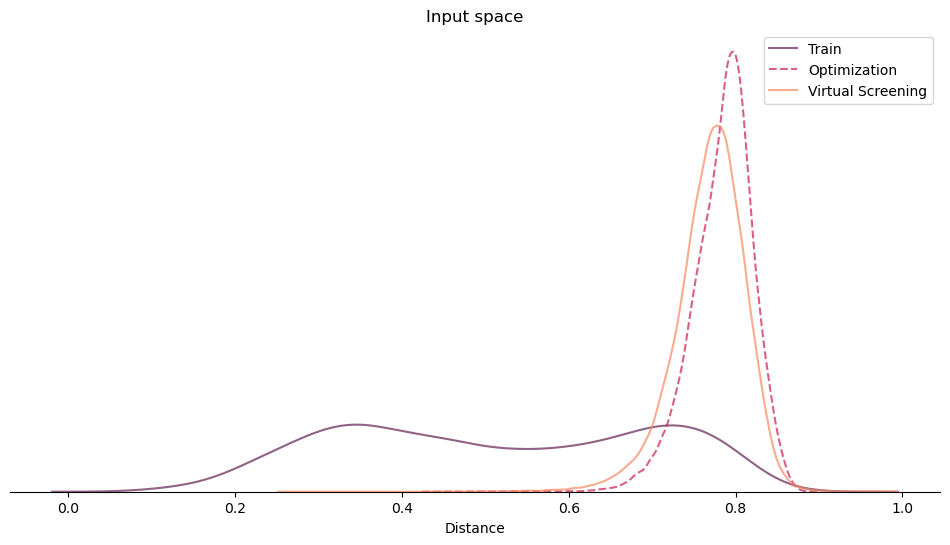

In [11]:
ax1 = plot_distance_distributions_2(input_distances, labels, colors, styles)
ax1.set_title("Input space")

Text(0.5, 1.0, 'MLP model space')

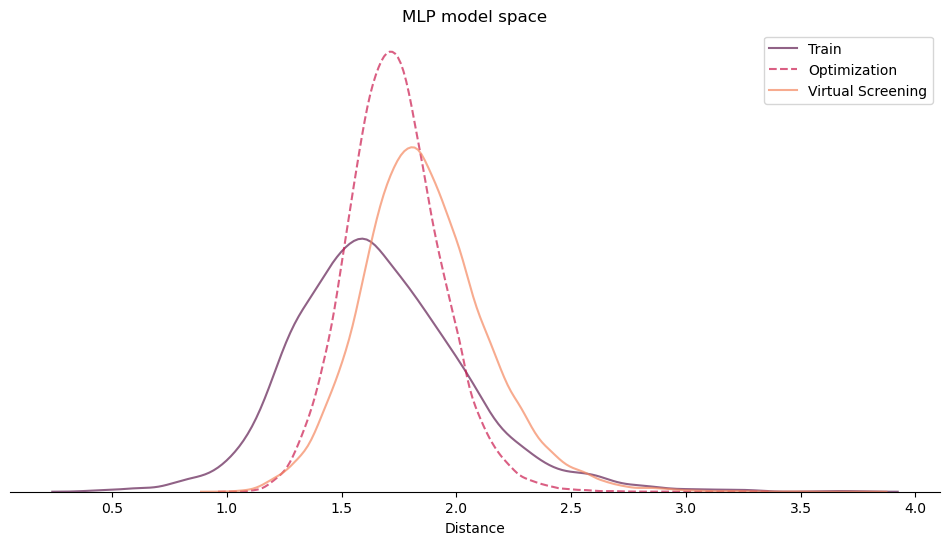

In [12]:
ax1 = plot_distance_distributions_2(mlp_distances, labels, colors, styles)
ax1.set_title("MLP model space")

Text(0.5, 1.0, 'RF model space')

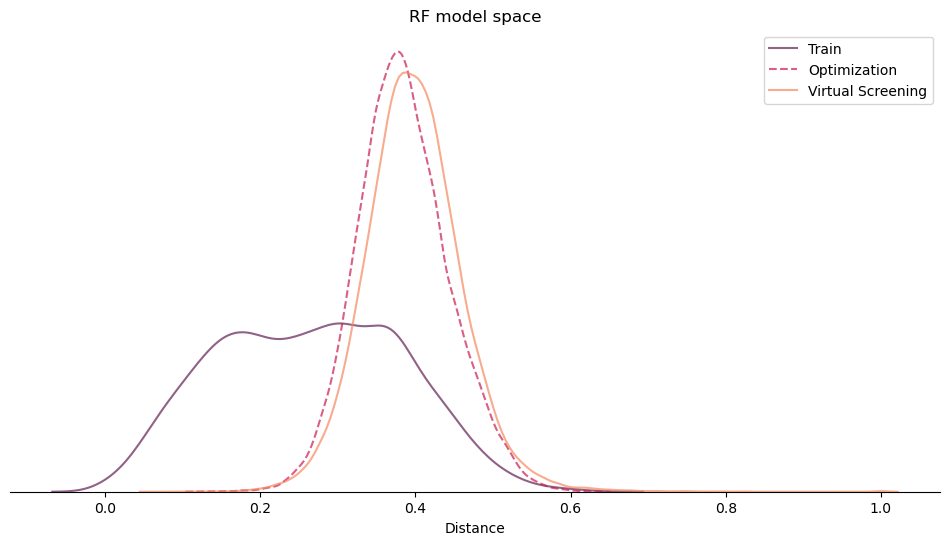

In [13]:
ax1 = plot_distance_distributions_2(rf_distances, labels, colors, styles)
ax1.set_title("RF model space")

The End.